# Bank Credit Risk Classification
By : [enricoroselino](https://www.linkedin.com/in/enricoroselino/)

Dataset : [ID/X Partners Virtual Intern Bank Loan Dataset]()

Objective : 
* Build a model that can **predict credit risk** using a dataset provided by the company consisting of **accepted and rejected data on loans**

Problem :
* there is no target column

Theoretical Basis :

**Bad credit** refers to an **individual's history of poor payment of bills and loans,** and the likelihood that he/she will not honor financial obligations in the future. A borrower with bad credit will find it **difficult to get their loan approved** because they are considered a credit risk. 
* Late payments : If you have delayed making payments for more than a month
* Charge-offs : If an account has become delinquent for too long
* Defaulting on loans : same as charge-offs, missed more than one payment and have not paid at the end of the month, the account is marked as in default.

[Corporate Finance Institute](https://corporatefinanceinstitute.com/resources/knowledge/credit/bad-credit-causes/)

**Being late by more than one month is considered delinquent**, However, delinquency is **not generally reported** to the major credit bureaus **until two consecutive monthly payments have been missed**. Delinquent accounts on a credit report can lower credit scores and reduce an individual's ability to borrow in the future.

In fact, while making one minimum payment keeps delinquency from worsening, making two decreases delinquency. If you are 90 days delinquent, for instance, then paying the amount equal to two minimum payments will bring you to 60 days.
[Investopedia](https://www.investopedia.com/articles/pf/11/intro-to-credit-card-delinquency.asp)

* **Current** means The borrower is making **payments on time**.
* **Grace period** is a set number of days **after the due date** during which payment may be made by the borrower **without penalty**.
* **Late** means the borrower **failed to make** a timely **payment within the grace period**. 
* **Default** means the **loan agreement has been terminated by the lending company**, and the outstanding balance of the loan is due and payable

[Mintos](https://www.mintos.com/blog/everything-you-wanted-to-know-about-loan-lifecycle-and-status/)

Summary : Credit Risk is based on loan status and how consistent borrower is making payments on time

risk_label feature description :
* 0 : high risk
* 1 : low risk

## Import Libs

In [1]:
import os
import math
import re
import pandas as pd
from datetime import date, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from fast_ml.model_development import train_valid_test_split
from scipy.stats import skew
from scipy import stats
from scipy.special import boxcox1p
from sklearn.decomposition import PCA

%matplotlib inline
sns.set()

## Load Data

In [2]:
data_path = os.path.join("dataset", "loan_data_2007_2014.csv")

In [3]:
loan_df = pd.read_csv(data_path, low_memory=False, index_col=0)

## Explore Data

In [4]:
loan_df.shape

(466285, 74)

In [5]:
loan_df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# drop columns that filled with all NaN values
loan_df = loan_df.dropna(axis = 1, how = "all")
# drop duplicated data
loan_df = loan_df.drop_duplicates()
loan_df.shape

(466285, 57)

In [7]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [8]:
col_names = ["id", "member_id"]
for i in loan_df[col_names] :
    print(f"{i} : {loan_df[i].nunique()}")

id : 466285
member_id : 466285


no duplicate `id` or `member_id`, the column will be discarded

### Missing Value Checking

In [9]:
check_missing = loan_df.isnull().sum() * 100 / loan_df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

mths_since_last_record         86.566585
mths_since_last_major_derog    78.773926
desc                           72.981546
mths_since_last_delinq         53.690554
next_pymnt_d                   48.728567
total_rev_hi_lim               15.071469
tot_cur_bal                    15.071469
tot_coll_amt                   15.071469
emp_title                       5.916553
emp_length                      4.505399
last_pymnt_d                    0.080637
revol_util                      0.072917
collections_12_mths_ex_med      0.031097
last_credit_pull_d              0.009007
inq_last_6mths                  0.006219
open_acc                        0.006219
total_acc                       0.006219
earliest_cr_line                0.006219
delinq_2yrs                     0.006219
acc_now_delinq                  0.006219
pub_rec                         0.006219
title                           0.004289
annual_inc                      0.000858
dtype: float64

Columns with missing values ​​above 75% will be discarded

### Check Categorical Features

In [10]:
loan_df.select_dtypes(include='object').nunique()

term                        2
grade                       7
sub_grade                  35
emp_title              205475
emp_length                 11
home_ownership              6
verification_status         3
issue_d                    91
loan_status                 9
pymnt_plan                  2
url                    466285
desc                   124436
purpose                    14
title                   63099
zip_code                  888
addr_state                 50
earliest_cr_line          664
initial_list_status         2
last_pymnt_d               98
next_pymnt_d              100
last_credit_pull_d        103
application_type            1
dtype: int64

disposal of features that have a very high unique value (high cardinality), features that only have one unique value and free text

### Check Numerical Features

In [11]:
loan_df.select_dtypes(exclude='object').nunique()

id                             466285
member_id                      466285
loan_amnt                        1352
funded_amnt                      1354
funded_amnt_inv                  9854
int_rate                          506
installment                     55622
annual_inc                      31901
dti                              3997
delinq_2yrs                        24
inq_last_6mths                     28
mths_since_last_delinq            145
mths_since_last_record            123
open_acc                           62
pub_rec                            26
revol_bal                       58142
revol_util                       1269
total_acc                         112
out_prncp                      135665
out_prncp_inv                  141189
total_pymnt                    351609
total_pymnt_inv                347659
total_rec_prncp                172713
total_rec_int                  270249
total_rec_late_fee               5808
recoveries                      22773
collection_r

there is only one type of value in `policy_code`, it will also be discarded

In [12]:
col_names = [
    "id", "member_id", "mths_since_last_record", "mths_since_last_major_derog",
    "sub_grade", "emp_title", "url", "desc", "title", "zip_code", "addr_state", "application_type",
    "policy_code"
]

In [13]:
loan_df = loan_df.drop(col_names, axis=1)

## DEFINE TARGET VARIABLE / LABELING

create a credit risk label feature based on `loan_status` which contains the behavior of the loan borrower.

In [14]:
loan_df["loan_status"].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [15]:
def status_labeler(status):
    LOW_RISK = re.compile(
            r"fully paid|current|in grace period"
    )
    LOAN_STATUS = status.lower()
    extract = LOW_RISK.search(LOAN_STATUS)
    if bool(extract) == True:
        state = 1
    else :
        state = 0
    return state

In [16]:
loan_df["credit_risk"] = loan_df["loan_status"].apply(status_labeler)

In [17]:
loan_df["credit_risk"].value_counts(normalize=True)*100

1    88.808132
0    11.191868
Name: credit_risk, dtype: float64

drop `loan_status`

In [18]:
loan_df = loan_df.drop(["loan_status"], axis=1)

## CLEANING, PREPROCESSING, FEATURE ENGINEERING

### emp_length

In [19]:
loan_df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [20]:
loan_df['emp_length_int'] = loan_df['emp_length'].str.replace(r"\+ years|\ years|\ year", '', regex=True)
loan_df['emp_length_int'] = loan_df['emp_length_int'].str.replace('< 1', str(0))
loan_df['emp_length_int'] = loan_df['emp_length_int'].astype(float)

In [21]:
loan_df = loan_df.drop(["emp_length"], axis=1)

### term

In [22]:
loan_df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [23]:
loan_df['term_int'] = loan_df['term'].str.replace('\ months', '').astype(float)

In [24]:
loan_df = loan_df.drop(["term"], axis=1)

### earliest_cr_line

In [25]:
loan_df['earliest_cr_line'].head(3)

0    Jan-85
1    Apr-99
2    Nov-01
Name: earliest_cr_line, dtype: object

In [26]:
loan_df['earliest_cr_line_date'] = pd.to_datetime(loan_df['earliest_cr_line'], format='%b-%y')
loan_df['earliest_cr_line_date'].head(3)

0   1985-01-01
1   1999-04-01
2   2001-11-01
Name: earliest_cr_line_date, dtype: datetime64[ns]

In [27]:
loan_df['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
loan_df['mths_since_earliest_cr_line'].head(3)

0    395.0
1    224.0
2    193.0
Name: mths_since_earliest_cr_line, dtype: float64

In [28]:
loan_df['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [29]:
loan_df[loan_df['mths_since_earliest_cr_line']<0][['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']].head(3)

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0
2799,Sep-64,2064-09-01,-561.0


python mistaken 1962 to 2062, replace it with max value because its very old

In [30]:
loan_df.loc[loan_df['mths_since_earliest_cr_line']<0, 'mths_since_earliest_cr_line'] = loan_df['mths_since_earliest_cr_line'].max()

In [31]:
loan_df = loan_df.drop(['earliest_cr_line', 'earliest_cr_line_date'], axis=1)

### issue_d

In [32]:
loan_df['issue_d_date'] = pd.to_datetime(loan_df['issue_d'], format='%b-%y')
loan_df['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['issue_d_date']) / np.timedelta64(1, 'M')))

In [33]:
loan_df['mths_since_issue_d'].describe()

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

In [34]:
loan_df = loan_df.drop(['issue_d', 'issue_d_date'], axis=1)

### last_pymnt_d

In [35]:
loan_df['last_pymnt_d_date'] = pd.to_datetime(loan_df['last_pymnt_d'], format='%b-%y')
loan_df['mths_since_last_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['last_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [36]:
loan_df['mths_since_last_pymnt_d'].describe()

count    465909.000000
mean         31.294369
std          12.809898
min          23.000000
25%          23.000000
50%          24.000000
75%          35.000000
max         120.000000
Name: mths_since_last_pymnt_d, dtype: float64

In [37]:
loan_df = loan_df.drop(['last_pymnt_d', 'last_pymnt_d_date'], axis=1)

### next_pymnt_d

In [38]:
loan_df['next_pymnt_d_date'] = pd.to_datetime(loan_df['next_pymnt_d'], format='%b-%y')
loan_df['mths_since_next_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['next_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [39]:
loan_df['mths_since_next_pymnt_d'].describe()

count    239071.000000
mean         22.738136
std           6.082298
min          21.000000
25%          22.000000
50%          22.000000
75%          22.000000
max         120.000000
Name: mths_since_next_pymnt_d, dtype: float64

In [40]:
loan_df = loan_df.drop(['next_pymnt_d', 'next_pymnt_d_date'], axis=1)

### last_credit_pull_d

In [41]:
loan_df['last_credit_pull_d_date'] = pd.to_datetime(loan_df['last_credit_pull_d'], format='%b-%y')
loan_df['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['last_credit_pull_d_date']) / np.timedelta64(1, 'M')))

In [42]:
loan_df['mths_since_last_credit_pull_d'].describe()

count    466243.000000
mean         27.045588
std           9.636423
min          23.000000
25%          23.000000
50%          23.000000
75%          25.000000
max         127.000000
Name: mths_since_last_credit_pull_d, dtype: float64

In [43]:
loan_df = loan_df.drop(['last_credit_pull_d', 'last_credit_pull_d_date'], axis=1)

### home_ownership

In [44]:
loan_df["home_ownership"].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [45]:
def home_ownership_simplify(status):
    SIMPLIFY = re.compile(
            r"none|any"
        )
    OWNERSHIP_STATUS = status.lower()
    extract = SIMPLIFY.search(OWNERSHIP_STATUS)
    if bool(extract) == True:
        state = "OTHER"
    else :
        state = status
    return state

In [46]:
loan_df["home_ownership_new"] = loan_df["home_ownership"].apply(home_ownership_simplify)

In [47]:
loan_df["home_ownership_new"].value_counts(normalize=True)*100

MORTGAGE    50.586015
RENT        40.420129
OWN          8.943886
OTHER        0.049969
Name: home_ownership_new, dtype: float64

In [48]:
loan_df = loan_df.drop(["home_ownership"], axis=1)

### verification_status

In [49]:
loan_df["verification_status"].unique()

array(['Verified', 'Source Verified', 'Not Verified'], dtype=object)

In [50]:
def verification_status_extract(status):
    SIMPLIFY = re.compile(
            r"not"
        )
    OWNERSHIP_STATUS = status.lower()
    extract = SIMPLIFY.search(OWNERSHIP_STATUS)
    if bool(extract) == True:
        state = 0
    else :
        state = 1
    return state

In [51]:
loan_df["verification_status_int"] = loan_df["verification_status"].apply(verification_status_extract)

In [52]:
loan_df["verification_status_int"].value_counts(normalize=True)*100

1    68.208928
0    31.791072
Name: verification_status_int, dtype: float64

In [53]:
loan_df = loan_df.drop(["verification_status"], axis=1)

## Data Visualization

### credit_risk

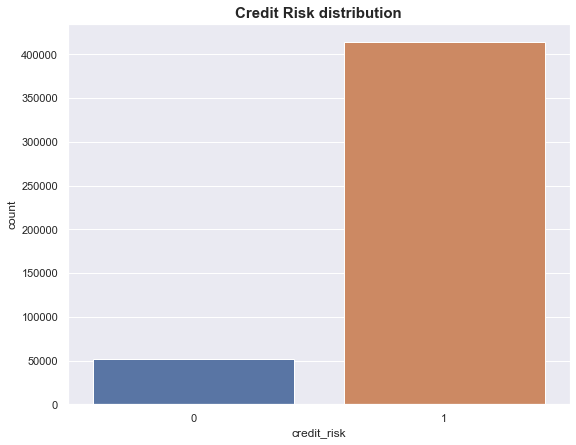

In [54]:
plt.figure(figsize=(9, 7))
sns.countplot(
    x= "credit_risk",
    data= loan_df
)
plt.title("Credit Risk distribution",
    loc="center",
    fontweight="bold",
    size=15
)
plt.show()

### verification_status

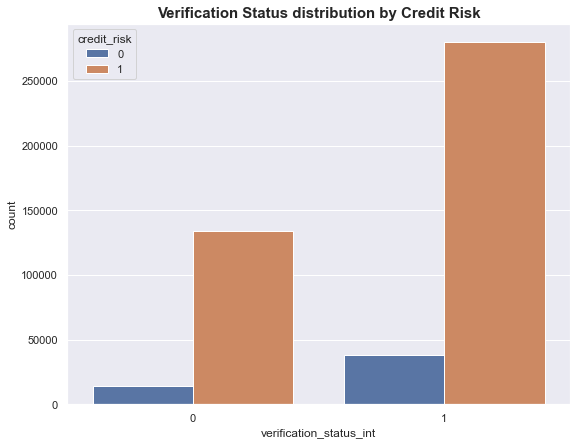

In [55]:
plt.figure(figsize=(9, 7))
sns.countplot(
    x= "verification_status_int",
    data= loan_df,
    hue = "credit_risk",
)
plt.title("Verification Status distribution by Credit Risk",
    loc="center",
    fontweight="bold",
    size=15
)
plt.show()

### Grade

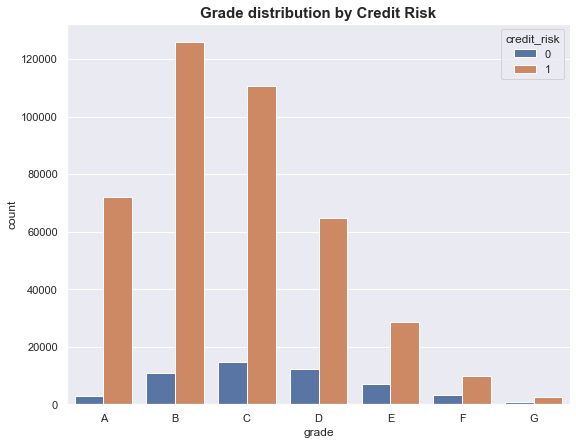

In [56]:
plt.figure(figsize=(9, 7))
sns.countplot(
    x= "grade",
    data= loan_df,
    hue = "credit_risk",
    order=["A", "B", "C", "D", "E", "F", "G"]
)
plt.title("Grade distribution by Credit Risk",
    loc="center",
    fontweight="bold",
    size=15
)
plt.show()

### funded_amnt

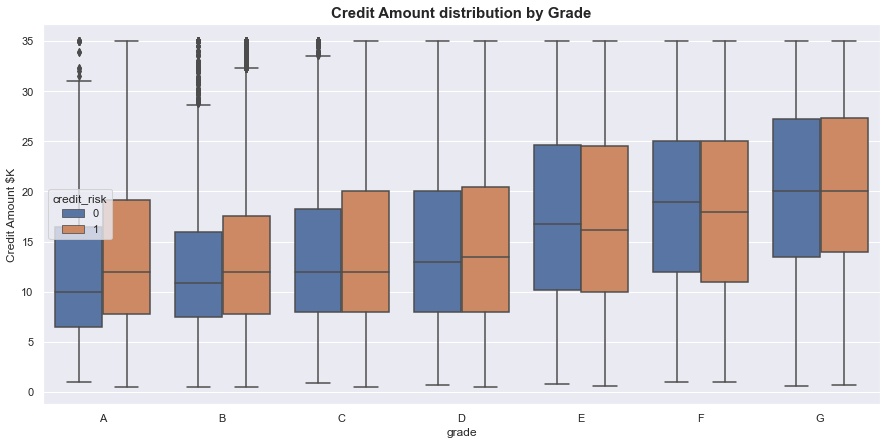

In [57]:
plt.figure(figsize=(15, 7))
sns.boxplot(
    x= "grade",
    y = loan_df.funded_amnt / 1000,
    data= loan_df,
    hue = "credit_risk",
    order=["A", "B", "C", "D", "E", "F", "G"]
)

plt.title("Credit Amount distribution by Grade",
    loc="center",
    fontweight="bold",
    size=15
)
plt.ylabel("Credit Amount $K")
plt.show()

### annual_inc

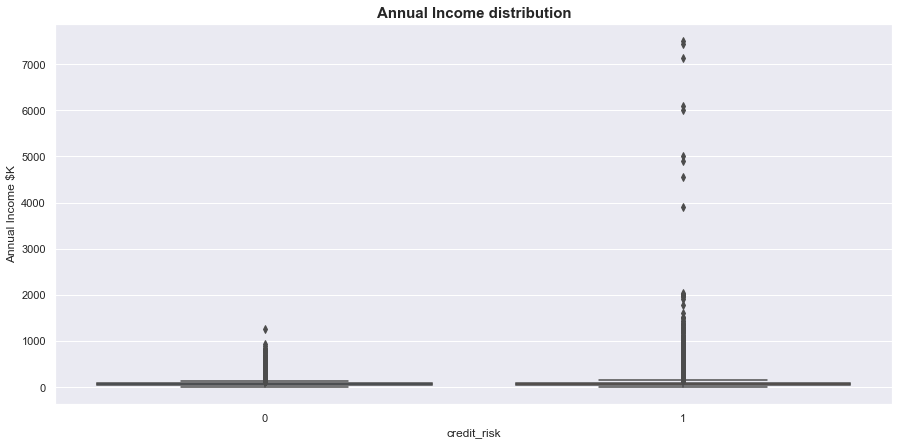

In [58]:
plt.figure(figsize=(15, 7))
sns.boxplot(
    x= "credit_risk",
    y = loan_df.annual_inc / 1000,
    data= loan_df
)
plt.title("Annual Income distribution",
    loc="center",
    fontweight="bold",
    size=15
)
plt.ylabel("Annual Income $K")
plt.show()

### home_ownership_new

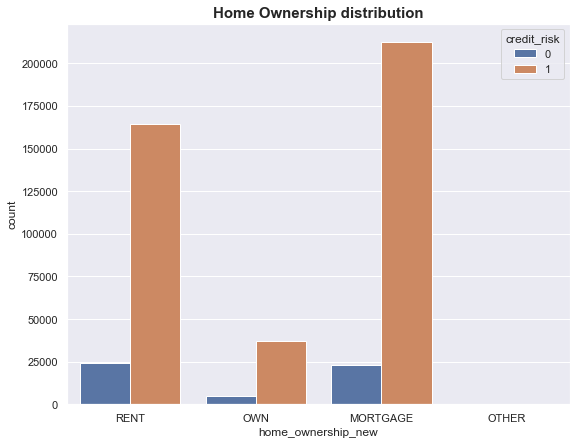

In [59]:
plt.figure(figsize=(9, 7))
sns.countplot(
    x= "home_ownership_new",
    hue = "credit_risk",
    data= loan_df
)
plt.title("Home Ownership distribution",
    loc="center",
    fontweight="bold",
    size=15
)
plt.show()

### purpose

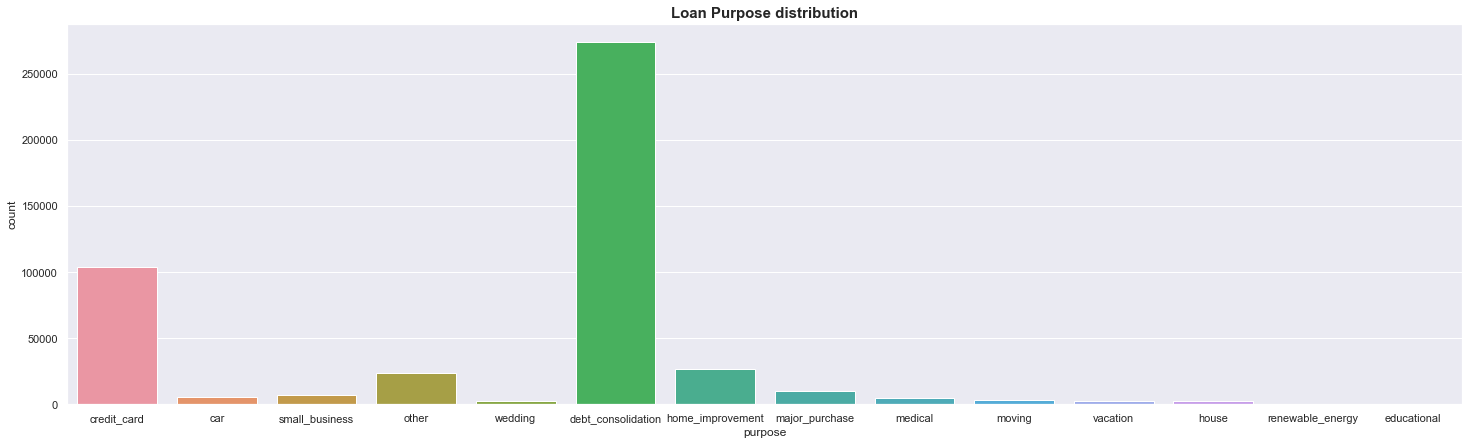

In [60]:
plt.figure(figsize=(25, 7))
sns.countplot(
    x= "purpose",
    data= loan_df
)
plt.title("Loan Purpose distribution",
    loc="center",
    fontweight="bold",
    size=15
)
plt.show()

## Correlation Check

### Numerical Correlation

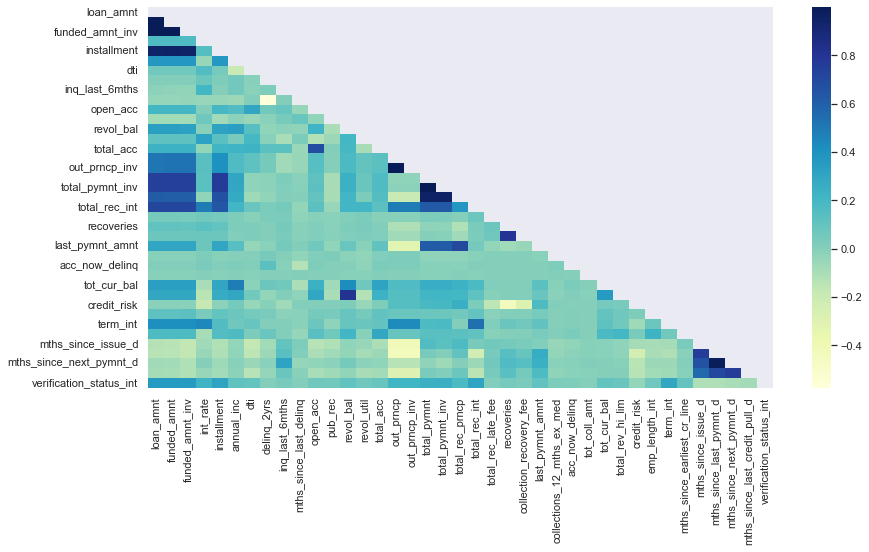

In [61]:
plt.figure(figsize=(14,7))
sns.heatmap(loan_df.corr(), cmap="YlGnBu", mask=np.triu(loan_df.corr()))
plt.show()

In [62]:
corr_matrix = loan_df.corr().abs()
to_pick_hicorr = corr_matrix.unstack()["credit_risk"].sort_values(kind="quicksort", ascending=False)

In [63]:
to_pick_hicorr

credit_risk                      1.000000
recoveries                       0.435352
collection_recovery_fee          0.295281
total_rec_prncp                  0.254255
mths_since_last_pymnt_d          0.237279
total_pymnt_inv                  0.194638
total_pymnt                      0.193977
int_rate                         0.174648
last_pymnt_amnt                  0.170164
total_rec_late_fee               0.151624
out_prncp                        0.150442
out_prncp_inv                    0.150430
mths_since_next_pymnt_d          0.142372
mths_since_last_credit_pull_d    0.131747
mths_since_issue_d               0.082961
inq_last_6mths                   0.073109
term_int                         0.064644
revol_util                       0.051020
tot_cur_bal                      0.050865
annual_inc                       0.049484
dti                              0.049092
total_rev_hi_lim                 0.037735
verification_status_int          0.034848
mths_since_earliest_cr_line      0

In [69]:
high_corr = to_pick_hicorr[to_pick_hicorr > 0.045]

In [70]:
high_corr

credit_risk                      1.000000
recoveries                       0.435352
collection_recovery_fee          0.295281
total_rec_prncp                  0.254255
mths_since_last_pymnt_d          0.237279
total_pymnt_inv                  0.194638
total_pymnt                      0.193977
int_rate                         0.174648
last_pymnt_amnt                  0.170164
total_rec_late_fee               0.151624
out_prncp                        0.150442
out_prncp_inv                    0.150430
mths_since_next_pymnt_d          0.142372
mths_since_last_credit_pull_d    0.131747
mths_since_issue_d               0.082961
inq_last_6mths                   0.073109
term_int                         0.064644
revol_util                       0.051020
tot_cur_bal                      0.050865
annual_inc                       0.049484
dti                              0.049092
dtype: float64

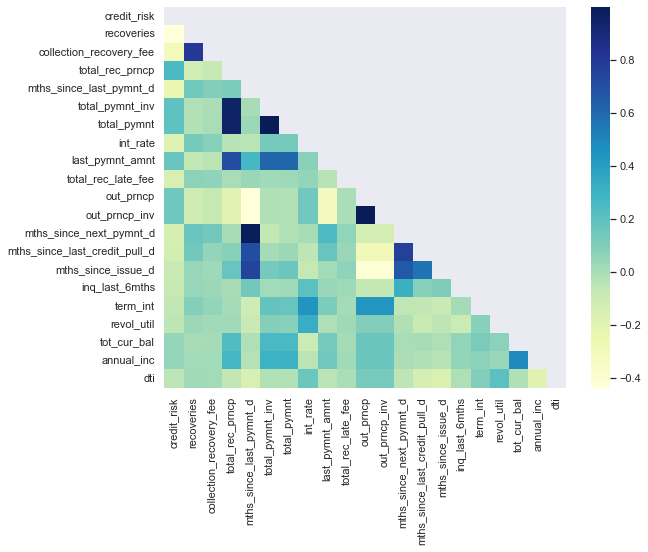

In [71]:
plt.figure(figsize=(9,7))
sns.heatmap(loan_df[high_corr.index.tolist()].corr(), cmap="YlGnBu", mask=np.triu(loan_df[high_corr.index.tolist()].corr()))
plt.show()

In [72]:
model_data = loan_df[high_corr.index.tolist()]

In [73]:
model_data.head(3)

,credit_risk,recoveries,collection_recovery_fee,total_rec_prncp,mths_since_last_pymnt_d,total_pymnt_inv,total_pymnt,int_rate,last_pymnt_amnt,total_rec_late_fee,...,out_prncp_inv,mths_since_next_pymnt_d,mths_since_last_credit_pull_d,mths_since_issue_d,inq_last_6mths,term_int,revol_util,tot_cur_bal,annual_inc,dti
0,1,0.00,0.00,5000.00,35.0,5831.78,5861.071414,10.65,171.62,0.0,...,0.0,NaN,23.0,72.0,1.0,36.0,83.7,NaN,24000.0,27.65
1,0,117.08,1.11,456.46,56.0,1008.71,1008.710000,15.27,119.66,0.0,...,0.0,NaN,51.0,72.0,5.0,60.0,9.4,NaN,30000.0,1.00
2,1,0.00,0.00,2400.00,42.0,3003.65,3003.653644,15.96,649.91,0.0,...,0.0,NaN,23.0,72.0,2.0,36.0,98.5,NaN,12252.0,8.72


### Missing Value Checking

In [74]:
check_missing = model_data.isnull().sum() * 100 / model_data.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

mths_since_next_pymnt_d          48.728567
tot_cur_bal                      15.071469
mths_since_last_pymnt_d           0.080637
revol_util                        0.072917
mths_since_last_credit_pull_d     0.009007
inq_last_6mths                    0.006219
annual_inc                        0.000858
dtype: float64

filling missing value with mean based on its credit_risk

In [75]:
for i in check_missing[check_missing > 0].index.tolist() :
    for j in range(model_data["credit_risk"].nunique()) :
        model_data[i].fillna(model_data[model_data["credit_risk"] == j][i].mean(), inplace=True)

In [76]:
model_data = pd.concat([model_data, loan_df.select_dtypes(include='object')], axis=1)

### Skewness Check

In [77]:
col_names = [col for col in model_data.columns.tolist() if col not in model_data.select_dtypes(include='object').columns.tolist() + ['credit_risk']]

recoveries : 13.149900072086655


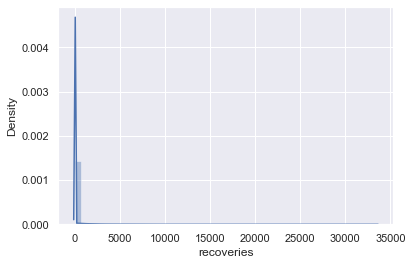

collection_recovery_fee : 22.23602399902316


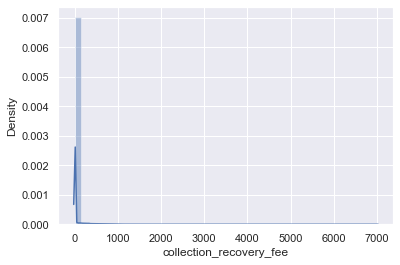

total_rec_prncp : 1.4455864178017124


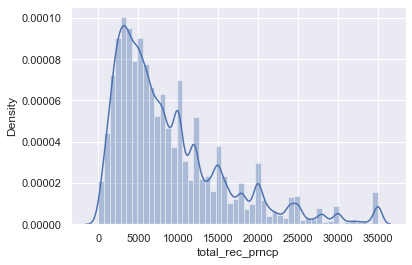

mths_since_last_pymnt_d : 2.234740695378259


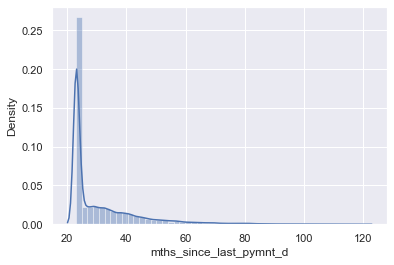

total_pymnt_inv : 1.4046539428532405


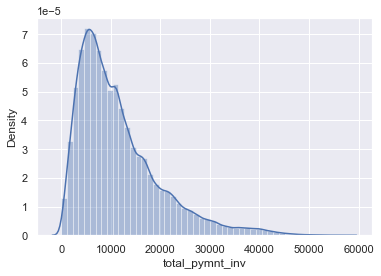

total_pymnt : 1.406398781194567


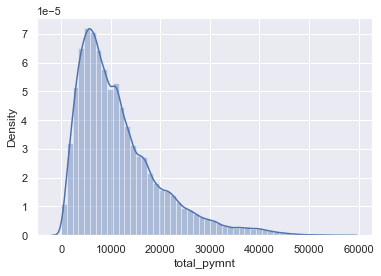

int_rate : 0.3349371579856011


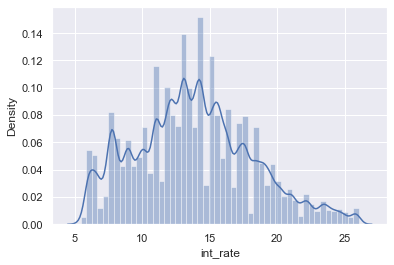

last_pymnt_amnt : 2.5606361381374563


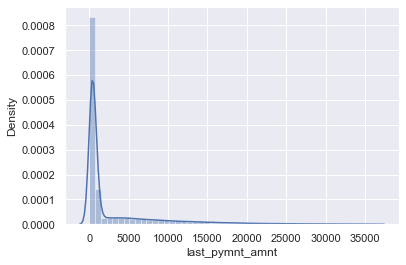

total_rec_late_fee : 13.843452891559188


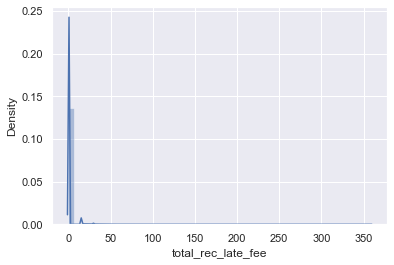

out_prncp : 1.59018345214046


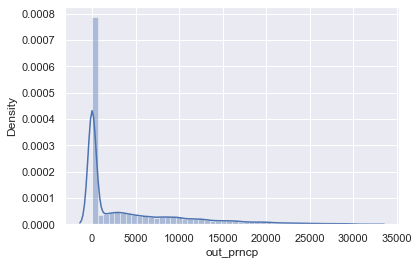

out_prncp_inv : 1.5904975896980664


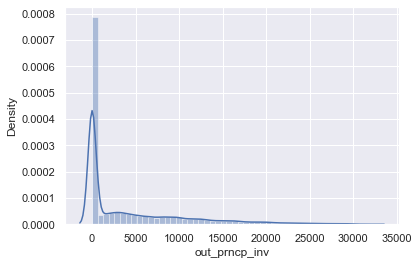

mths_since_next_pymnt_d : 9.507982470559993


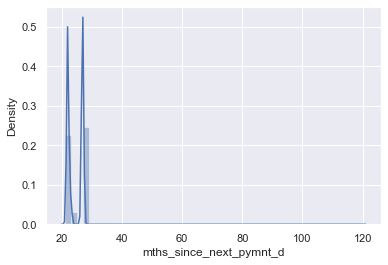

mths_since_last_credit_pull_d : 3.5157886237095974


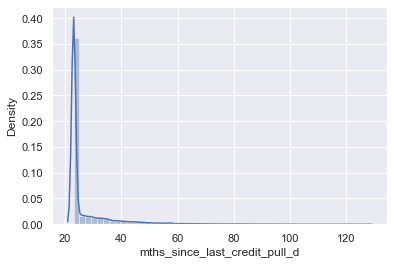

mths_since_issue_d : 1.720363708387957


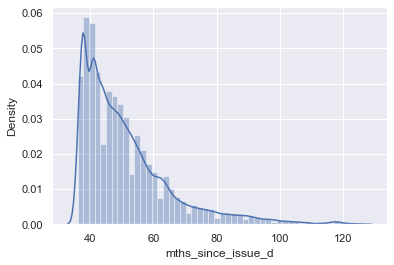

inq_last_6mths : 2.14215674261115


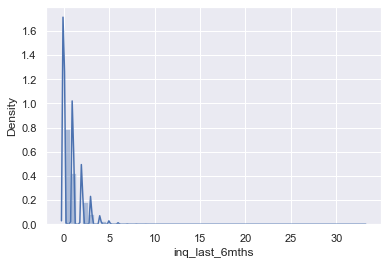

term_int : 1.0065588094120295


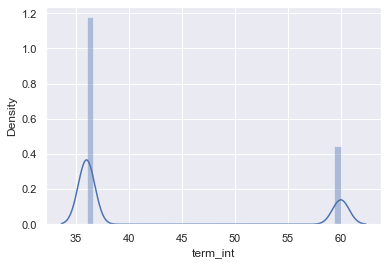

revol_util : -0.16132847589067098


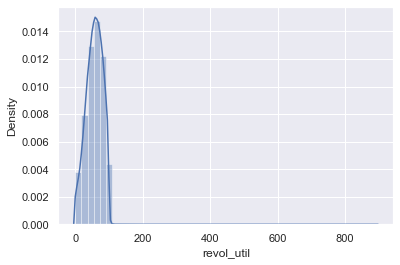

tot_cur_bal : 3.363175692822635


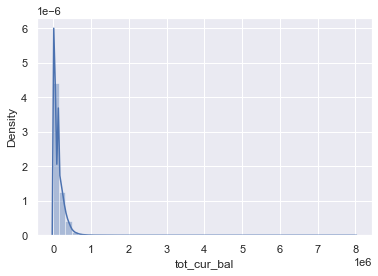

annual_inc : 29.56893325427021


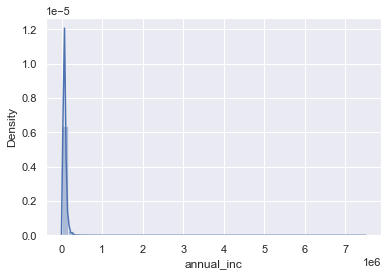

dti : 0.18828264942483444


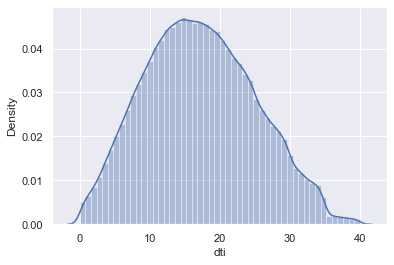

In [78]:
for i in col_names :
    print(f"{i} : {skew(model_data[i])}")
    plt.figure(figsize=(6,4))
    sns.distplot(model_data[i])
    plt.show()

## FEATURE SCALING AND TRANSFORMATION

### Normal Transform

boxcox transform except `dti`, `revol_util` and `int_rate` because the distribution is already near normal.

In [79]:
col_names = [col for col in col_names if col not in ["dti", "revol_util", "int_rate"]]

In [80]:
for i in col_names :
    try :
        print(f"{i} after transformation : {skew(stats.boxcox(model_data[i])[0])}")
        model_data[i] = stats.boxcox(model_data[i])[0]
    except :
        print(f"{i} after transformation : {skew(boxcox1p(model_data[i], 0.25))}")
        model_data[i] = boxcox1p(model_data[i], 0.25)

recoveries after transformation : 4.75999163705126
collection_recovery_fee after transformation : 6.766581488876611
total_rec_prncp after transformation : 0.015406506968194426
mths_since_last_pymnt_d after transformation : 0.48865421466602366
total_pymnt_inv after transformation : -0.07196589439962948
total_pymnt after transformation : 0.013688811430040453
last_pymnt_amnt after transformation : 1.108015504426153
total_rec_late_fee after transformation : 7.048920682944638
out_prncp after transformation : 0.26641891018406044
out_prncp_inv after transformation : 0.2664854273741098
mths_since_next_pymnt_d after transformation : 0.1350675593877218
mths_since_last_credit_pull_d after transformation : 1.164787662218518
mths_since_issue_d after transformation : 0.14014247656233242
inq_last_6mths after transformation : 0.8669862850277965
term_int after transformation : 1.0065553389043143
tot_cur_bal after transformation : 0.08010923904385116
annual_inc after transformation : -0.0128509595667027

### One Hot Encoding

In [81]:
categorical_cols = model_data.select_dtypes(include='object').columns.tolist()
ohe = pd.get_dummies(model_data[categorical_cols])

In [82]:
ohe.head()

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,pymnt_plan_n,pymnt_plan_y,purpose_car,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,home_ownership_new_MORTGAGE,home_ownership_new_OTHER,home_ownership_new_OWN,home_ownership_new_RENT
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


In [83]:
model_data = pd.concat([model_data.drop(categorical_cols, axis=1), ohe], axis=1)

### Standardization

In [84]:
numerical_cols = [col for col in model_data.columns.tolist() if col not in ohe.columns.tolist() + ['credit_risk']]

In [85]:
scaler = StandardScaler()
model_data[numerical_cols] = scaler.fit_transform(model_data[numerical_cols])

In [86]:
model_data.head(3)

,credit_risk,recoveries,collection_recovery_fee,total_rec_prncp,mths_since_last_pymnt_d,total_pymnt_inv,total_pymnt,int_rate,last_pymnt_amnt,total_rec_late_fee,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,home_ownership_new_MORTGAGE,home_ownership_new_OTHER,home_ownership_new_OWN,home_ownership_new_RENT
0,1,-0.219325,-0.180691,-0.390324,0.971694,-0.603691,-0.620021,-0.729587,-0.892134,-0.148552,...,0,0,0,0,1,0,0,0,0,1
1,0,1.839020,0.233023,-2.382716,1.646270,-2.276683,-2.322040,0.330634,-1.014032,-0.148552,...,0,0,0,0,1,0,0,0,0,1
2,1,-0.219325,-0.180691,-1.132284,1.333793,-1.323905,-1.356140,0.488979,-0.332022,-0.148552,...,0,1,0,0,1,0,0,0,0,1


### PCA
my computer gonna catch fire without reducing the feature dimension

In [87]:
pca_cols = [col for col in model_data.columns.tolist() if col not in ['credit_risk']]

In [88]:
pca = PCA(n_components = 0.6)
pca_data = pca.fit_transform(model_data[pca_cols])

In [91]:
pca_data = pd.DataFrame(pca_data)

In [92]:
pca_data = pd.concat([pca_data, model_data["credit_risk"]], axis=1)

In [93]:
pca_data.head()

,0,1,2,3,4,credit_risk
0,0.936218,2.096698,-0.766685,1.241497,0.307330,1
1,1.292504,5.267349,0.891073,-0.763252,-3.754201,0
2,0.874875,3.391995,-0.477003,2.040011,-1.085506,1
3,2.609463,1.204213,-0.147610,-0.158793,-0.469244,1
4,-1.805877,1.125988,0.034100,-0.296321,-0.388090,1


### Data Split

In [94]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(pca_data, target = 'credit_risk', 
                                                                            train_size=0.6, valid_size=0.3, test_size=0.1, random_state=42)

### Class Balancing

In [95]:
oversample = SMOTETomek(random_state = 42, n_jobs= -1)
X_train, y_train = oversample.fit_resample(X_train, y_train)

## Machine Learning Model

### Deep Neural Network

### Random Forest

In [96]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, confusion_matrix

In [141]:
rfc = RandomForestClassifier(max_depth=16, random_state=42, n_jobs=-1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, n_jobs=-1, random_state=42)

In [142]:
arr_feature_importances = rfc.feature_importances_
arr_feature_names = X_train.columns.values
    
df_feature_importance = pd.DataFrame(index=range(len(arr_feature_importances)), columns=['feature', 'importance'])
df_feature_importance['feature'] = arr_feature_names
df_feature_importance['importance'] = arr_feature_importances
df_all_features = df_feature_importance.sort_values(by='importance', ascending=False)
df_all_features

,feature,importance
1,1,0.380611
2,2,0.241598
0,0,0.235005
3,3,0.073242
4,4,0.069544


#### Analyze Random Forest

In [143]:
val_result = rfc.predict(X_valid)

In [144]:
print(classification_report(list(y_valid), val_result))

              precision    recall  f1-score   support

           0       0.68      0.78      0.73     15786
           1       0.97      0.95      0.96    124099

    accuracy                           0.93    139885
   macro avg       0.82      0.87      0.84    139885
weighted avg       0.94      0.93      0.94    139885



In [145]:
f1 = f1_score(list(y_valid), val_result)
print(f1 * 100)

96.19618519739386


In [146]:
recall = recall_score(list(y_valid), val_result)
print(recall * 100)

95.23847895631712


In [147]:
prec = precision_score(list(y_valid), val_result)
print(prec * 100)

97.17334824218108


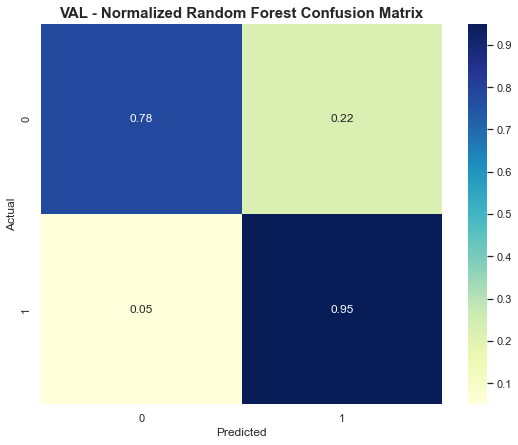

In [148]:
cm = confusion_matrix(list(y_valid), val_result)
cm_norm = np.round(cm / np.sum(cm, axis=1).reshape(-1,1), 2)
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm_norm, 
    cmap="YlGnBu", 
    annot=True
)
plt.title("VAL - Normalized Random Forest Confusion Matrix",
    loc="center",
    fontweight="bold",
    size=15
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## TEST DATA

In [149]:
RFC_test_preds = rfc.predict(X_test)

In [150]:
print(f"f1 score Random Forest Classifier : {round(f1_score(list(y_test), RFC_test_preds), 4) * 100}%")

f1 score Random Forest Classifier : 96.3%


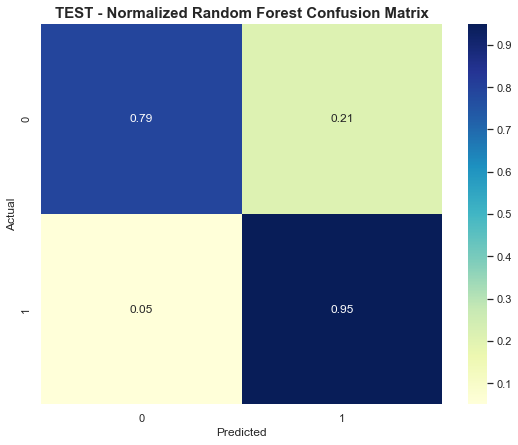

In [152]:
cm = confusion_matrix(list(y_test), RFC_test_preds)
cm_norm = np.round(cm / np.sum(cm, axis=1).reshape(-1,1), 2)
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm_norm, 
    cmap="YlGnBu", 
    annot=True
)
plt.title("TEST - Normalized Random Forest Confusion Matrix",
    loc="center",
    fontweight="bold",
    size=15
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()